In [17]:
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 

from astropy.table import Table, Column, vstack, join

import numpy as np 
from numpy.lib.recfunctions import append_fields

import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 25})

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
               '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
               '#bcbd22', '#17becf']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### HSC data

* **1-D stellar mass**: `s16a_wide2_massive_fsps1_imgsub_use_short.fits`

In [5]:
s16a_dir = '/Users/song/data/massive/dr16a/'

logm_sbp = Table.read(
    os.path.join(s16a_dir, 'sbp/catalog', 's16a_wide2_massive_fsps1_imgsub_use_short.fits'))

print('# 1-D stellar mass: {}'.format(len(logm_sbp)))

logm_cmod = Table.read(
    os.path.join(s16a_dir, 'galaxy', 's16a_wide_sed_cmodel_mass.fits'))

print('# CModel stellar mass: {}'.format(len(logm_cmod)))

# 1-D stellar mass: 38653
# CModel stellar mass: 684049


In [55]:
logm_cmod.colnames

['object_id',
 'ra',
 'dec',
 'a_g',
 'a_r',
 'a_i',
 'a_z',
 'a_y',
 'clean_photometry',
 'brightstar_mask_acturus',
 'z_spec',
 'z_best',
 'z_phot',
 'z_type',
 'z_source',
 'gcountinputs',
 'rcountinputs',
 'icountinputs',
 'zcountinputs',
 'ycountinputs',
 'gcmodel_mag',
 'gcmodel_mag_err',
 'rcmodel_mag',
 'rcmodel_mag_err',
 'icmodel_mag',
 'icmodel_mag_err',
 'zcmodel_mag',
 'zcmodel_mag_err',
 'ycmodel_mag',
 'ycmodel_mag_err',
 'gcmodel_flux',
 'gcmodel_flux_err',
 'rcmodel_flux',
 'rcmodel_flux_err',
 'icmodel_flux',
 'icmodel_flux_err',
 'zcmodel_flux',
 'zcmodel_flux_err',
 'ycmodel_flux',
 'ycmodel_flux_err',
 'gcmodel_flux_flags',
 'rcmodel_flux_flags',
 'icmodel_flux_flags',
 'zcmodel_flux_flags',
 'ycmodel_flux_flags',
 'gparent_mag_convolved_2_2',
 'gparent_mag_convolved_2_2_err',
 'gparent_flux_convolved_2_2',
 'gparent_flux_convolved_2_2_err',
 'gdetected_notjunk',
 'gparent_flux_convolved_flag',
 'gparent_flux_convolved_2_deconv',
 'rparent_mag_convolved_2_2',
 'rpa

In [252]:
# Only keep the useful columns

logm_sbp_use = logm_sbp[
    'object_id', 'logm_10', 'logm_100', 'logm_max'
]

logm_cmod_use = logm_cmod[
    'object_id', 'ra', 'dec', 'z_best', 'z_spec', 
    'gcmodel_mag', 'rcmodel_mag', 'icmodel_mag', 'zcmodel_mag', 'ycmodel_mag',
    'MSTAR', 'AGE', 'TAU', 'ZMETAL', 'AV',
    'ABSMAG_G', 'ABSMAG_R', 'ABSMAG_I', 'ABSMAG_Z', 'ABSMAG_Y'
]

In [253]:
logm_cmod_use.rename_column('MSTAR', 'logm_cmod')
logm_cmod_use.rename_column('AGE', 'age_ised')
logm_cmod_use.rename_column('TAU', 'tau_ised')
logm_cmod_use.rename_column('ZMETAL', 'zmet_ised')
logm_cmod_use.rename_column('AV', 'av_ised')
logm_cmod_use.rename_column('ABSMAG_G', 'amag_g_ised')
logm_cmod_use.rename_column('ABSMAG_R', 'amag_r_ised')
logm_cmod_use.rename_column('ABSMAG_I', 'amag_i_ised')
logm_cmod_use.rename_column('ABSMAG_Z', 'amag_z_ised')
logm_cmod_use.rename_column('ABSMAG_Y', 'amag_y_ised')

In [254]:
# Join the table
logm_both = join(logm_cmod_use, logm_sbp_use, keys='object_id', join_type='left')

logm_both['logm_10'].fill_value = np.nan
logm_both['logm_100'].fill_value = np.nan
logm_both['logm_max'].fill_value = np.nan

logm_both = logm_both.filled()

In [255]:
color_mask = ((logm_both['gcmodel_mag'] - logm_both['rcmodel_mag'] > 0.5) &
              (logm_both['gcmodel_mag'] - logm_both['rcmodel_mag'] < 2.3) &
              (logm_both['rcmodel_mag'] - logm_both['icmodel_mag'] > 0.2) &
              (logm_both['rcmodel_mag'] - logm_both['icmodel_mag'] < 1.3) &
              (logm_both['icmodel_mag'] - logm_both['zcmodel_mag'] > 0.0) &
              (logm_both['icmodel_mag'] - logm_both['zcmodel_mag'] < 0.7) &
              (logm_both['zcmodel_mag'] - logm_both['ycmodel_mag'] > -0.1) &
              (logm_both['zcmodel_mag'] - logm_both['ycmodel_mag'] < 0.5)
             )

print(color_mask.sum(), len(color_mask))

logm_use = logm_both[color_mask]

626494 684049


### Explore the difference between 1-D and CModel mass

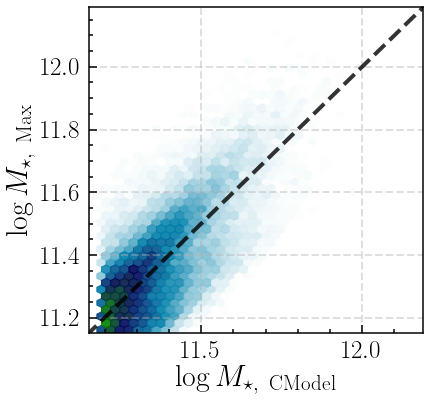

In [257]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)


ax1.hexbin(logm_use['logm_cmod'], logm_use['logm_max'],
           alpha=0.9, gridsize=(35, 35), cmap='ocean_r', rasterized=True)

ax1.plot([11.0, 12.5], [11.0, 12.5], linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(11.15, 12.19)
_ = ax1.set_ylim(11.15, 12.19)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm CModel}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max}$', fontsize=30)

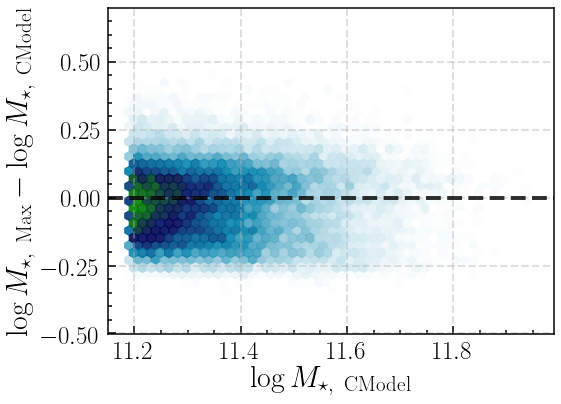

In [258]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['logm_cmod'], logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(60, 20), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(11.15, 11.99)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm CModel}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

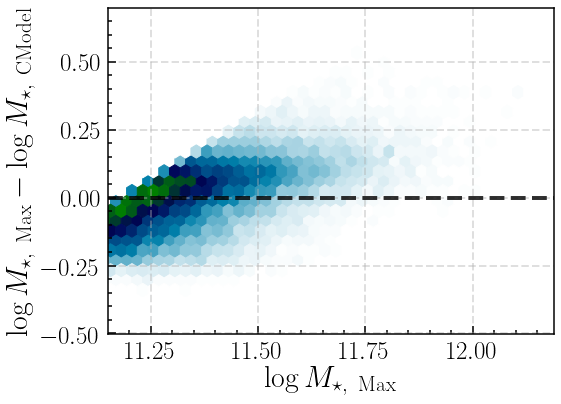

In [121]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['logm_max'], logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=1.0, gridsize=(60, 15), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(11.15, 12.19)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \rm Max}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

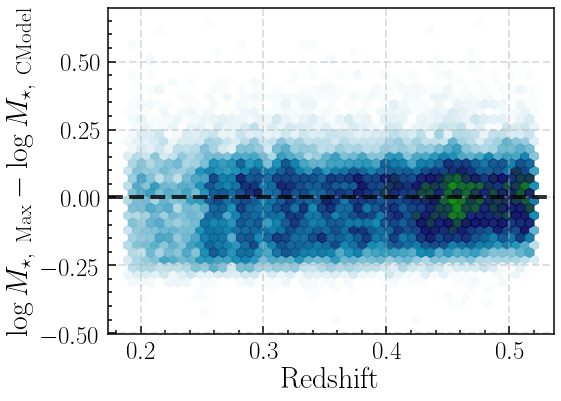

In [122]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['z_best'], logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(45, 20), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

#_ = ax1.set_xlim(0.09, 25)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\rm Redshift$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

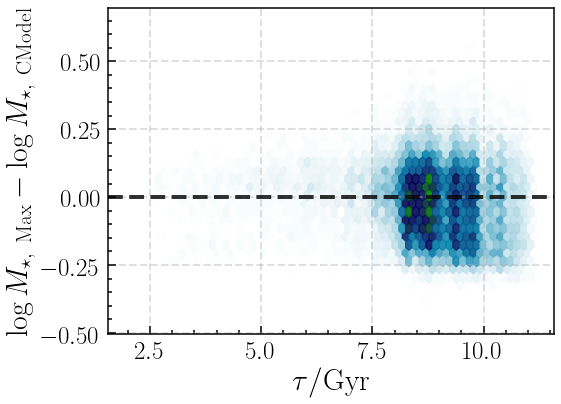

In [264]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['age_ised'], logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(60, 18), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

#_ = ax1.set_xlim(0.0, 2.5)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\tau/\rm Gyr$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

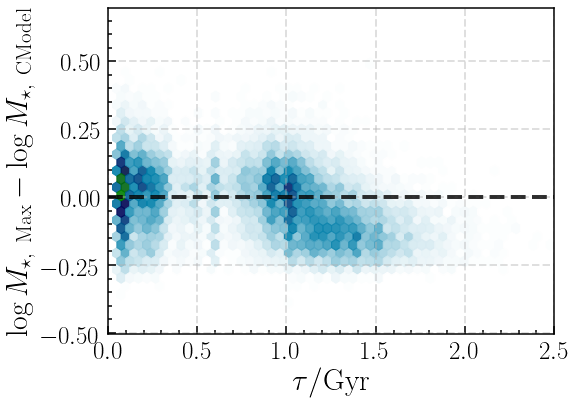

In [123]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['tau_ised'], logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(60, 18), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(0.0, 2.5)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$\tau/\rm Gyr$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

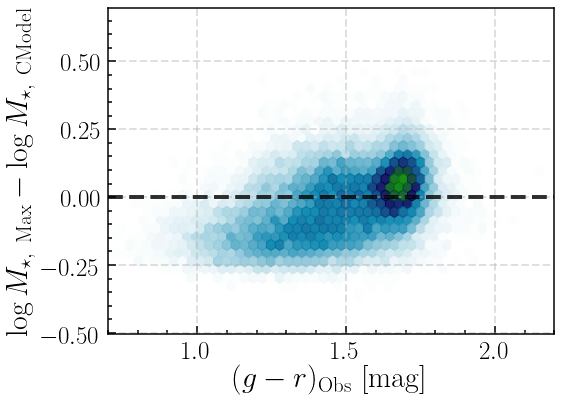

In [247]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['gcmodel_mag'] - logm_use['rcmodel_mag'], 
           logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(60, 18), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(0.7, 2.2)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$(g-r)_{\rm Obs}\ [\rm mag]$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

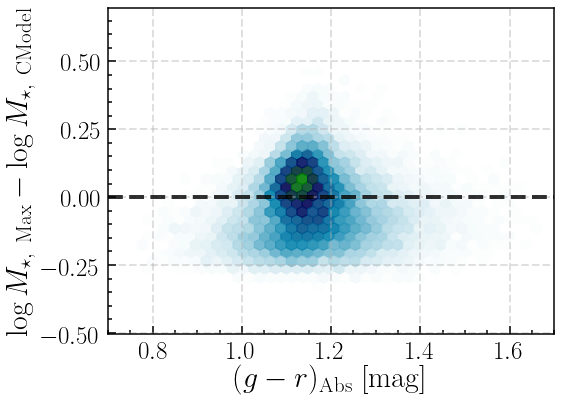

In [250]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.8)

ax1.hexbin(logm_use['amag_g_ised'] - logm_use['amag_i_ised'], 
           logm_use['logm_max'] - logm_use['logm_cmod'],
           alpha=0.9, gridsize=(60, 18), cmap='ocean_r', rasterized=True)

ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

_ = ax1.set_xlim(0.7, 1.7)
#_ = ax1.set_ylim(0.45, 1.55)

_ = ax1.set_xlabel(r'$(g-r)_{\rm Abs}\ [\rm mag]$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \rm Max} - \log M_{\star,\ \rm CModel}$', fontsize=30)

### Training a model

In [211]:
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

np.random.seed(6564)

In [259]:
# Sample with useful 1-D mass
logm_1d_use = logm_use[np.isfinite(logm_use['logm_max'])]

In [261]:
X = np.stack(
        [logm_1d_use['logm_cmod'], logm_1d_use['tau_ised'],
         logm_1d_use['gcmodel_mag'], logm_1d_use['rcmodel_mag'], 
         logm_1d_use['icmodel_mag'], logm_1d_use['zcmodel_mag'], 
         logm_1d_use['amag_g_ised'], logm_1d_use['amag_i_ised'], 
        ]
    ).T

y = np.asarray(logm_1d_use['logm_max'])


print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

(38494, 8) (38494,)


In [208]:
# kNN regressor: does not work very well

n_neighbors = 7

knn_dist= neighbors.KNeighborsRegressor(n_neighbors, weights='distance',
                                        algorithm='brute')

y_knn_dist = knn_dist.fit(X_train, y_train)

In [239]:
# Random forest regressor

rf_regr = RandomForestRegressor(
    max_depth=None, random_state=0, n_estimators=100, criterion='mse',
    bootstrap=False)

rf_regr.fit(X_train, y_train)

print(rf_regr.feature_importances_)

[0.4222313  0.20209102 0.09803747 0.10150994 0.08319074 0.09293953]


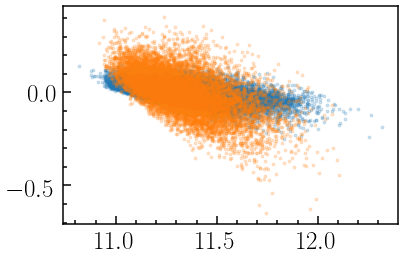

In [240]:
plt.scatter(y_train, rf_regr.predict(X_train) - y_train, alpha=0.2, s=8)

plt.scatter(y_test, rf_regr.predict(X_test) - y_test, alpha=0.2, s=8)